# Tutorial: Camera-data Fitting

Cameras used in Cherenkov air shower astronomy usually consist of many PMT pixels. A common calibration procedure for these cameras is to measure the SPE spectra in each pixel. This tutorial demonstrates the conveniance classes useful for fitting the data taken in such a procedure.

In [1]:
from spefit.fitter import CameraFitter
from spefit.pdf.pmt_single_gaussian import PMTSingleGaussian
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

/Users/Jason/Software/spefit/spefit/fitter.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


## The Dataset

Create a test dataset via inverse transform sampling from the single-photoelectron PDF for a simple PMT, for n_pixels

(10000, 1000)


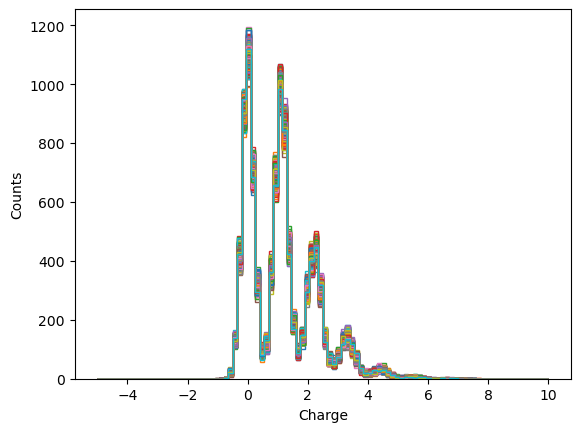

In [2]:
pdf = PMTSingleGaussian(n_illuminations=1)
x = np.linspace(-10, 100, 10000)
n_pixels = 1000
pixel_charges_list = []

fig, ax = plt.subplots()
ax.set_xlabel("Charge")
ax.set_ylabel("Counts")

parameters = {}
for ipix in range(n_pixels):
    parameters = dict(
        eped=0,
        eped_sigma=0.2,
        pe=1.1,
        pe_sigma=0.1,
        lambda_ =1
    )
    y = pdf.function(x, **parameters)  # Calculate PDF via the direct call to the PDF function
    c = np.random.choice(x, p=y / y.sum(), size=10000)  # Inverse transform sampling
    pixel_charges_list.append(c)
    
    ax.hist(c, bins=100, range=[-5, 10], histtype='step')
    
pixel_charges = np.array(pixel_charges_list).T
print(pixel_charges.shape)

`pixel_charges` is a numpy array containing the charges measured in each of the 1000 pixel for each of the from 10000 calibration events

## CameraFitter

The `CameraFitter` is a conveniance class for fitting data of this form. For each pixel, it stores the charges measured into the `CameraContainer`, and performs the minimisation to get the best-fit values for each pixel. Each pixel can be processed in series (with `CameraFitter.process`), or in parallel over multiple CPU cores with the `multiprocessing` package (with `CameraFitter.multiprocess`).

In [3]:
CameraFitter?

In [4]:
fitter = CameraFitter(pdf=pdf, n_bins=100, range_=(-5, 10), cost_name="BinnedNLL")
charges = [pixel_charges]  # A list of size n_illuminations is expected, only 1 illumination is considered here
fitter.multiprocess(charges, n_processes=3)

Multiprocessing pixel SPE fit (n_processes = 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

## Demonstrate Results

The results of the fit are obtainable through the attributes of the `CameraFitter`:
- `pixel_values` contains the best-fit values per pixel
- `pixel_errors` contains the errors on the the best-fit values per pixel
- `pixel_scores` contains the score of the minimisation (e.g. p-value)
- `pixel_arrays` contains the fit and charge curves for plotting (per pixel, per illumination)

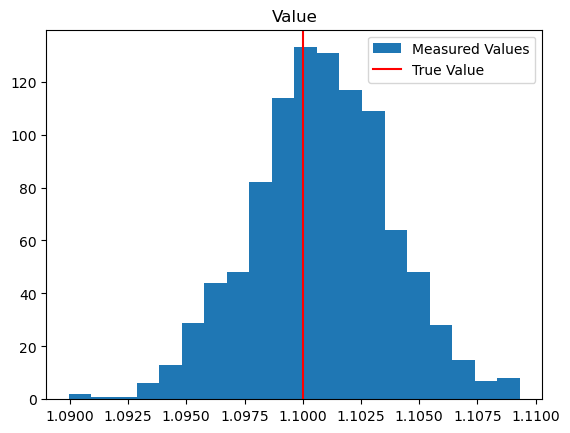

In [5]:
fig, ax = plt.subplots()
pe = np.zeros(n_pixels)
for ipix in range(n_pixels):
    pe[ipix] = fitter.pixel_values[ipix]['pe']
ax.hist(pe, bins=20, label="Measured Values")
ax.axvline(parameters['pe'], color='red', label="True Value")
ax.legend()
_ = ax.set_title("Value")

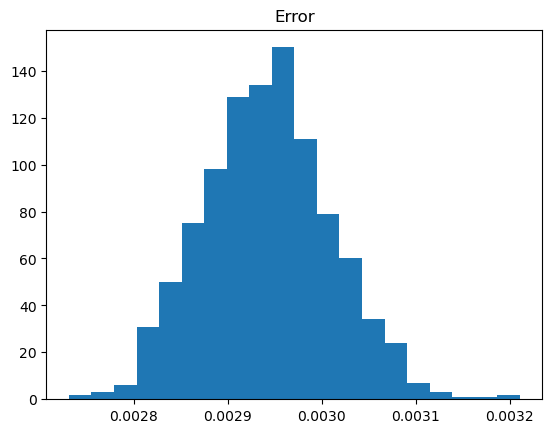

In [6]:
fig, ax = plt.subplots()
pe = np.zeros(n_pixels)
for ipix in range(n_pixels):
    pe[ipix] = fitter.pixel_errors[ipix]['pe']
ax.hist(pe, bins=20, label="Measured Values")
_ = ax.set_title("Error")

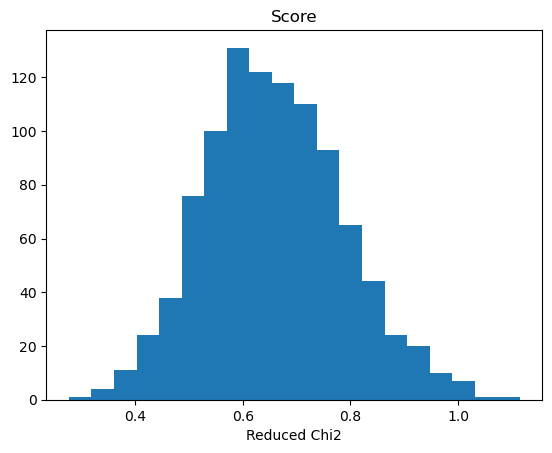

In [7]:
fig, ax = plt.subplots()
pe = np.zeros(n_pixels)
for ipix in range(n_pixels):
    pe[ipix] = fitter.pixel_scores[ipix]['reduced_chi2']
ax.hist(pe, bins=20, label="Measured Values")
ax.set_xlabel("Reduced Chi2")
_ = ax.set_title("Score")

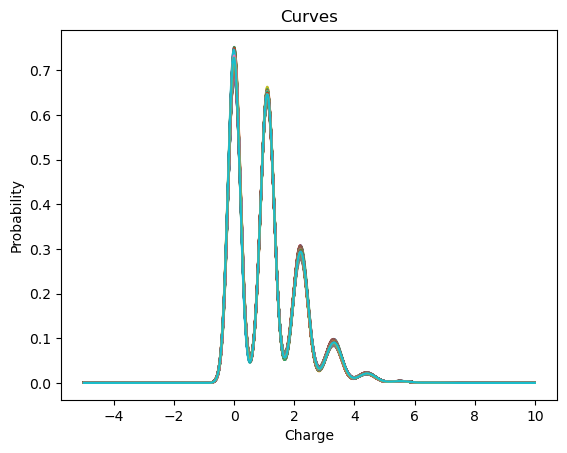

In [8]:
fig, ax = plt.subplots()
pe = np.zeros(n_pixels)
illumination = 0
for ipix in range(n_pixels):
    ax.plot(fitter.pixel_arrays[ipix][illumination]['fit_x'], fitter.pixel_arrays[ipix][illumination]['fit_y'])
ax.set_title("Curves")
ax.set_xlabel("Charge")
_ = ax.set_ylabel("Probability")